In [1]:
import os
import random
import itertools
from PIL import Image

#--------------------------------------------------------------------------------------#

import numpy as np
import pandas as pd

#--------------------------------------------------------------------------------------#

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#--------------------------------------------------------------------------------------#

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

#--------------------------------------------------------------------------------------#

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#--------------------------------------------------------------------------------------#

import warnings
warnings.filterwarnings("ignore")

In [6]:
print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Tensorflow Version: 2.15.0
GPU Available: []


In [4]:
# helper functions

#--------------------------------------------------------------------------------------#

def generate_dataset(path):
    data = {'imgpath': [], 'labels': []}

    folders = os.listdir(path)

    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)

        for file in files:
            filepath = os.path.join(folderpath, file)

            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    return pd.DataFrame(data)

#--------------------------------------------------------------------------------------#

def set_seed(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)

#--------------------------------------------------------------------------------------#

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import PIL
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_path = '/content/drive/MyDrive/work/MIP/Project_Data/train'
val_path = '/content/drive/MyDrive/work/MIP/Project_Data/val'
test_path =  '/content/drive/MyDrive/work/MIP/Project_Data/test'

## <div style="font-size: 110%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Organizing the Images 📂</div>


**To structure the given images into a dataset, we'll create a table with two columns: "imgpath" and "label". The "imgpath" column will contain the file paths to each image, serving as a reference to their locations in our storage. Meanwhile, the "label" column will assign a category to each image, distinguishing between normal chest X-rays and those indicating pneumonia. This organization facilitates efficient access to the images during model training and evaluation. By structuring the dataset in this manner, we establish a clear association between images and their corresponding labels, laying the groundwork for effective development and utilization of our pneumonia detection model.**

In [10]:
train_df = generate_dataset(train_path).sample(frac = 1, random_state = 0).reset_index(drop = True)
val_df = generate_dataset(val_path).sample(frac = 1, random_state = 0).reset_index(drop = True)
test_df = generate_dataset(test_path).sample(frac = 1, random_state = 0).reset_index(drop = True)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')
print(f'\nTesting Dataframe of shape {test_df.shape}: \n{test_df.head()}')


Training Dataframe of shape (3466, 2): 
                                             imgpath     labels
0  /content/drive/MyDrive/work/MIP/Project_Data/t...     NORMAL
1  /content/drive/MyDrive/work/MIP/Project_Data/t...     NORMAL
2  /content/drive/MyDrive/work/MIP/Project_Data/t...  PNEUMONIA
3  /content/drive/MyDrive/work/MIP/Project_Data/t...  PNEUMONIA
4  /content/drive/MyDrive/work/MIP/Project_Data/t...  PNEUMONIA

Validation Dataframe of shape (18, 2): 
                                             imgpath     labels
0  /content/drive/MyDrive/work/MIP/Project_Data/v...     NORMAL
1  /content/drive/MyDrive/work/MIP/Project_Data/v...     NORMAL
2  /content/drive/MyDrive/work/MIP/Project_Data/v...     NORMAL
3  /content/drive/MyDrive/work/MIP/Project_Data/v...  PNEUMONIA
4  /content/drive/MyDrive/work/MIP/Project_Data/v...  PNEUMONIA

Testing Dataframe of shape (624, 2): 
                                             imgpath     labels
0  /content/drive/MyDrive/work/MIP/Project_Data

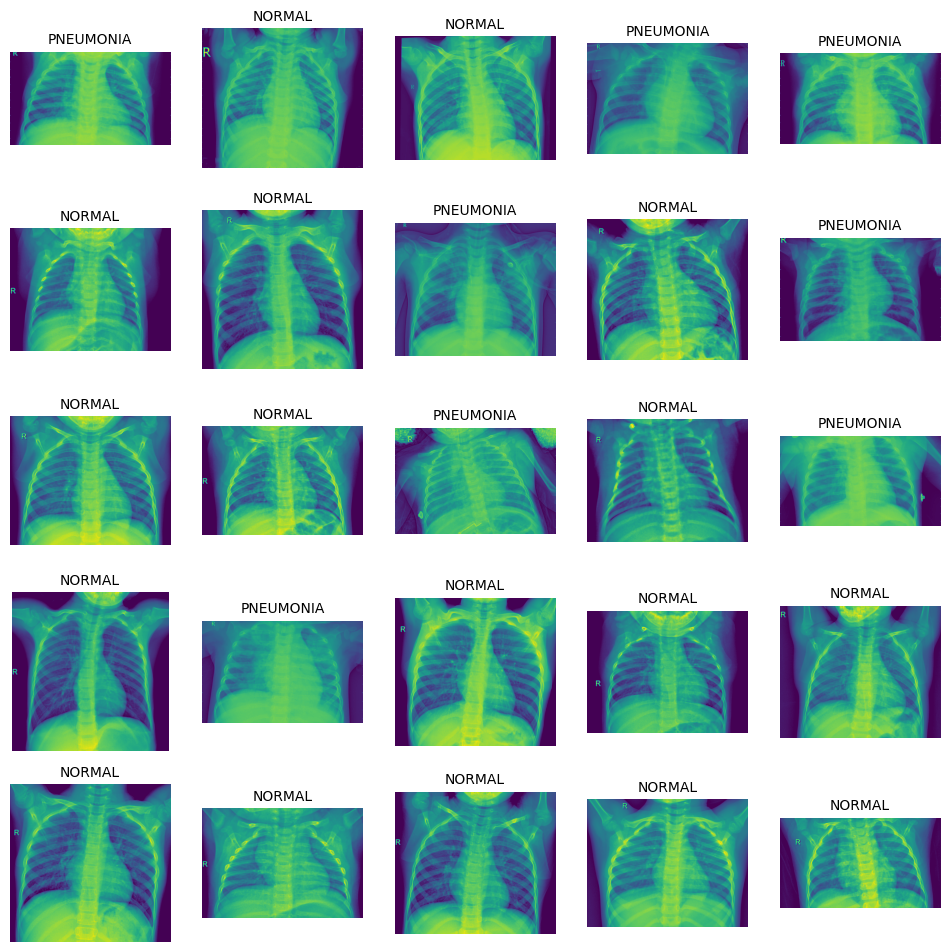

In [11]:
rows = 5
cols = 5

dataset = pd.concat([train_df, test_df, val_df])

selected_indices = random.sample(range(len(dataset)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, 12))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = dataset['imgpath'].iloc[idx]
    label = dataset['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

### <div style="font-size: 100%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Distribution of Labels 📊</div>

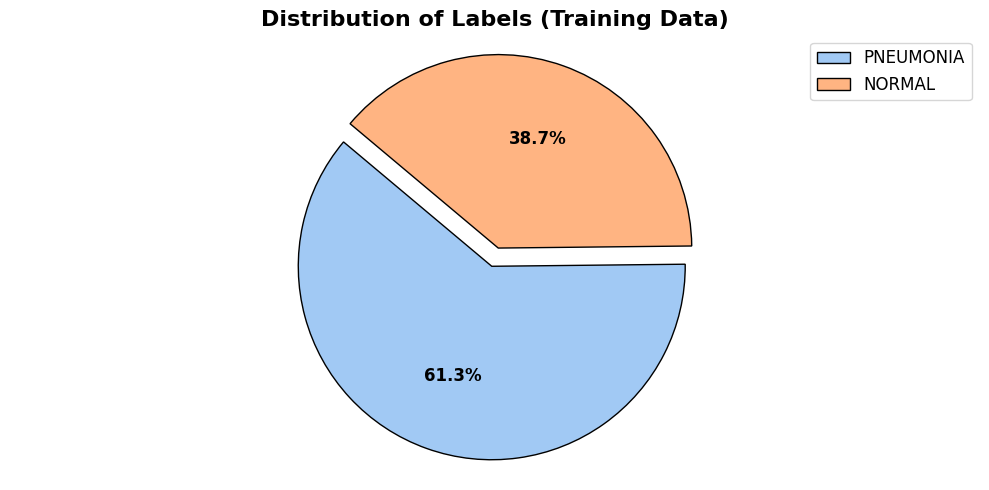

In [12]:
dataset = train_df

fig, ax = plt.subplots(figsize = (10, 5))

labels = dataset['labels'].value_counts().index
sizes = dataset['labels'].value_counts().values
colors = sns.color_palette('pastel')

wedges, texts, autotexts = ax.pie(sizes, colors = colors,
                                  autopct = '%1.1f%%', startangle = 140,
                                  explode = (0.1, 0), wedgeprops = dict(edgecolor = 'black'))

ax.set_title('Distribution of Labels (Training Data)', fontsize = 16, fontweight = 'bold')
ax.axis('equal')
ax.legend(wedges, labels, loc = "best", fontsize = 12)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [13]:
%%time

BATCH_SIZE = 16
IMG_SHAPE = (128, 128)
SEED = 0
EPOCHS = 10

traingen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 10,
                              width_shift_range = 0.02,
                              height_shift_range = 0.02,
                              zoom_range = 0.05,
                              horizontal_flip = True)

testgen = ImageDataGenerator(rescale = 1./255)

train_images = traingen.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels',
                                            class_mode = 'binary', color_mode = 'rgb',
                                            batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                            shuffle = True, seed = SEED)

val_images = testgen.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels',
                                         class_mode = 'binary', color_mode = 'rgb',
                                         batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                         shuffle = False)

test_images = testgen.flow_from_dataframe(test_df, x_col = 'imgpath', y_col = 'labels',
                                          class_mode = 'binary', color_mode = 'rgb',
                                          batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                          shuffle = False)

Found 3465 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
CPU times: user 70.2 ms, sys: 286 ms, total: 356 ms
Wall time: 726 ms


# <div style="font-size: 120%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Creating and Training the Classifier 🛠️</div>


**Our starting model for pneumonia detection is VGG16, a reliable convolutional neural network known for its effectiveness in image tasks. We'll fine-tune VGG16 to better suit our pneumonia detection task, aiming for accurate identification of normal and pneumonia-infected chest X-ray images. This process ensures our model adapts well to the complexities of pneumonia classification, striving for high accuracy in diagnosis.**

## <div style="font-size: 110%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Fine-tuning ResNet50 🔧</div>

In [14]:
base_model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet',
                   input_shape = IMG_SHAPE + (3,), pooling = 'avg')

for layer in base_model.layers[:-10]:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


## <div style="font-size: 110%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Configuring and Compiling Classifier 💻</div>

In [15]:
model = Sequential([
    Input(shape = IMG_SHAPE + (3,), name = 'input_layer'),
    base_model,

    BatchNormalization(),

    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(1, activation = 'sigmoid', name = 'output_layer')
])

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

## <div style="font-size: 110%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Training the Classifier 🎓</div>

In [16]:
%%time

set_seed(SEED)

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

history = model.fit(train_images, validation_data = val_images,
                    epochs = EPOCHS, callbacks = [model_es, model_rlr])

Epoch 1/12
217/217 [==============================] - 639s 3s/step - loss: 1.9886 - accuracy: 0.8753 - val_loss: 1.8410 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
217/217 [==============================] - 66s 302ms/step - loss: 1.0331 - accuracy: 0.9238 - val_loss: 1.7519 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
217/217 [==============================] - 66s 302ms/step - loss: 0.5848 - accuracy: 0.9287 - val_loss: 1.5330 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/12
217/217 [==============================] - 66s 302ms/step - loss: 0.3790 - accuracy: 0.9290 - val_loss: 0.9559 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/12
217/217 [==============================] - 65s 301ms/step - loss: 0.3090 - accuracy: 0.9276 - val_loss: 0.3522 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/12
217/217 [==============================] - 65s 302ms/step - loss: 0.2448 - accuracy: 0.9299 - val_loss: 0.4725 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/12
217/217 [==============================] - 

# <div style="font-size: 120%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Evaluating the Classifier 📏</div>

In [17]:
test_results = model.evaluate(test_images, verbose = 0)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')

Test Loss: 0.65906
Test Accuracy: 80.61%


In [18]:
class_labels = list(train_images.class_indices.keys())

test_classes = test_images.classes
predicted_classes = np.round(model.predict(test_images, verbose = 0))

print(f'Classification Report (Test) --> \n\n' + \
f'{classification_report(test_classes, predicted_classes, target_names = class_labels)}')

Classification Report (Test) --> 

              precision    recall  f1-score   support

      NORMAL       0.92      0.53      0.67       234
   PNEUMONIA       0.78      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624



## <div style="font-size: 110%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Evaluation Visualization 📊</div>

### <div style="font-size: 100%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Accuracy and Loss Curve 📈</div>

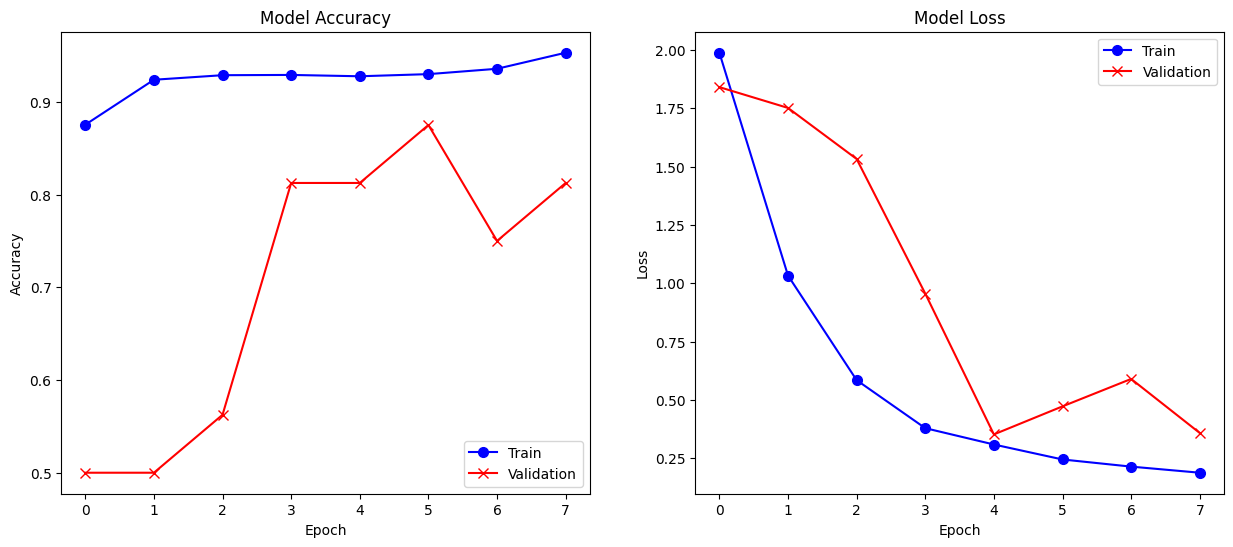

In [19]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# accuracy

ax[0].plot(history.history['accuracy'], marker = 'o', color = 'blue', markersize = 7)
ax[0].plot(history.history['val_accuracy'], marker = 'x', color = 'red', markersize = 7)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# loss

ax[1].plot(history.history['loss'], marker = 'o', color = 'blue', markersize = 7)
ax[1].plot(history.history['val_loss'], marker = 'x', color = 'red', markersize = 7)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [20]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
print(f'Best Epoch: {best_epoch}')

Best Epoch: 6


### <div style="font-size: 100%; font-weight: bold; background-color: #f2f2f2; color: #990000; border-radius: 12px; padding: 25px; text-align: center; margin-bottom: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); margin-bottom: -15px;">Confusion Matrix 📊</div>

<Figure size 1000x1000 with 0 Axes>

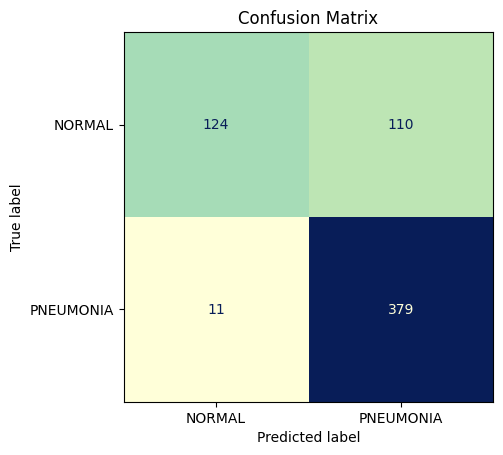

In [21]:
test_matrix = confusion_matrix(test_classes, predicted_classes)

class_labels = list(test_images.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')

plt.show()